In [25]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# setting up kaggle to download dataset
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
# downloading dataset
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset -p /content/drive/MyDrive/Simpsons

100% 1.08G/1.08G [01:01<00:00, 19.8MB/s]
100% 1.08G/1.08G [01:01<00:00, 18.9MB/s]


In [ ]:
# unzipping the dataset
!unzip /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset.zip -d /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/

In [3]:
# initializing variables
IMG_SIZE = (60, 60)
CHANNELS = 1
data_dir = r'/content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset'
TEST_SIZE = 0.4

In [4]:
def load_data():
  # storing character name and quantity in a dictonary
  data_dict = {}
  for data in os.listdir(data_dir):
    data_dict[data] = len(os.listdir(os.path.join(data_dir, data)))

  # sorting dictonary in decending order of values of dictonary
  data_dict = sorted(data_dict.items(), key=lambda x:x[1], reverse=True)

  # getting top 10 classes with max samples 
  classes = []
  count = 0
  for i in data_dict:
    classes.append(i[0])
    count += 1
    if count >= 10:
      break
  print("top 10 classes:", classes)

  # loading data
  features = []
  labels = []
  for folder in classes:
    folder_path = os.path.join(data_dir, folder)
    folder_label = classes.index(folder)
    # message
    if os.path.isdir(folder_path):
      print(f"Loading files from {folder_path}")
    # appending data with features and labels
    for file in os.listdir(folder_path):
      # preprocessing data
      img = cv.imread(os.path.join(folder_path, file))
      img = cv.resize(img, IMG_SIZE)
      img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      features.append(img)
      labels.append(folder_label)

  return features, labels, classes

In [5]:
# loading data
features, labels, classses = load_data()

# converting integer labeles to binary matrices to use categorical_crossentropy loss fn
labels = tf.keras.utils.to_categorical(labels)

# performing train test split
x_train, x_test, y_train, y_test =  train_test_split(np.array(features), np.array(labels), test_size=TEST_SIZE)

top 10 classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/homer_simpson
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/ned_flanders
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/moe_szyslak
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/bart_simpson
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/marge_simpson
Loading files from /content/drive/MyDrive/Simpsons/the-simpsons-characters-dataset/simpsons_dataset/krusty_the_clow

13811 13811
image shape: (60, 60)


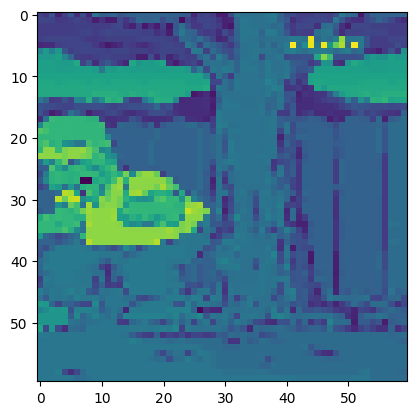

In [6]:
print(len(features), len(labels))
print("image shape:", features[0].shape)
plt.imshow(features[0])
plt.show()

In [55]:
def get_model():
    # defining model
    model = tf.keras.models.Sequential([
        
        # adding convolutional layer with 128 filters by 3x3 kernal
        tf.keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(60, 60, 1)),
        
        # adding max_pooling layer with pool size 2x2 with 10% dropout
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.10),
        
        # adding convolutional layer with 252 filters by 3x3 kernal
        tf.keras.layers.Conv2D(252, (3,3), activation="relu"),
        
        # adding max_pooling layer with pool size 2x2 with 25% dropout
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # adding convolutional layer with 256 filters by 6x6 kernal
        tf.keras.layers.Conv2D(512, (3,3), activation="relu"),
        
        # adding max_pooling layer with pool size 2x2 with 10% dropout
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.10),

        # flattening all the units with dropout with 30%
        tf.keras.layers.Flatten(),
        
        # adding hidden layer with 1024 units with 45% dropout
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.45),

        # adding hidden layer with 512 units with 25% dropout
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.25),
        
        # adding output layer with 10 units to get probablity for 10 digits with softmax activation fn
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
    # compiling model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # getting model summary
    model.summary()
    return model

In [56]:
# getting model
model = get_model()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 58, 58, 128)       1280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 29, 29, 128)      0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 29, 29, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 252)       290556    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 13, 13, 252)      0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 13, 13, 252)      

In [57]:
# training model
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_test,  y_test))

Epoch 1/40
259/259 [==============================] - 10s 27ms/step - loss: 3.7443 - accuracy: 0.1535 - val_loss: 2.2821 - val_accuracy: 0.1678
Epoch 2/40
259/259 [==============================] - 7s 28ms/step - loss: 2.2861 - accuracy: 0.1609 - val_loss: 2.2650 - val_accuracy: 0.1698
Epoch 3/40
259/259 [==============================] - 7s 27ms/step - loss: 2.2528 - accuracy: 0.1774 - val_loss: 2.1917 - val_accuracy: 0.2105
Epoch 4/40
259/259 [==============================] - 7s 27ms/step - loss: 2.2187 - accuracy: 0.1891 - val_loss: 2.1692 - val_accuracy: 0.2063
Epoch 5/40
259/259 [==============================] - 7s 27ms/step - loss: 2.1906 - accuracy: 0.2003 - val_loss: 2.1267 - val_accuracy: 0.2290
Epoch 6/40
259/259 [==============================] - 9s 34ms/step - loss: 2.1166 - accuracy: 0.2370 - val_loss: 2.0288 - val_accuracy: 0.2833
Epoch 7/40
259/259 [==============================] - 10s 39ms/step - loss: 2.0506 - accuracy: 0.2673 - val_loss: 2.0185 - val_accuracy: 0.29

173/173 - 1s - loss: 1.2767 - accuracy: 0.6700 - 1s/epoch - 6ms/step


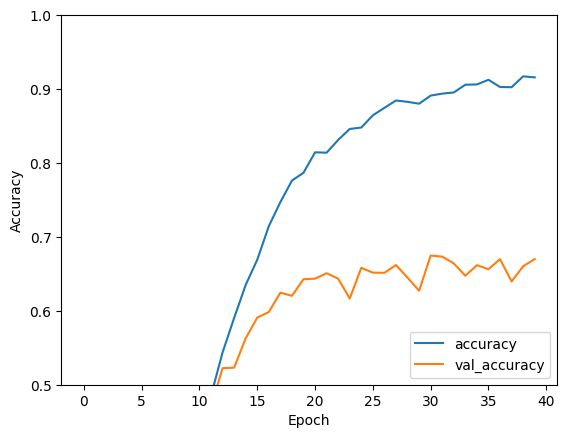

In [58]:
# plotting evaluation graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Evaluating the model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [59]:
def predict(img):
  img = cv.imread(img)
  img = cv.resize(img, (60, 60))
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = np.expand_dims(img, axis=0)
  predictions = model.predict(img)
  predictions = classses[np.argmax(predictions)]
  return predictions

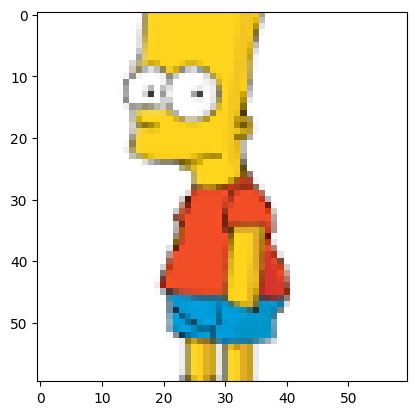

1/1 [==============================] - 0s 82ms/step
lisa_simpson


In [60]:
test_img = r"/content/test.png"

image = cv.imread(test_img)
image = cv.resize(image, (60,60))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

prediction = predict(test_img)
print(prediction)

In [63]:
filename = "simpsons.h5"
model.save(filename)